# Exercises 9: Independent Component Analysis #

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import fractional_matrix_power
from scipy.stats import kurtosis
from scipy.io.wavfile import write
from sklearn.decomposition import FastICA

## 1. Entropy Minimization ##

(2, 20000)


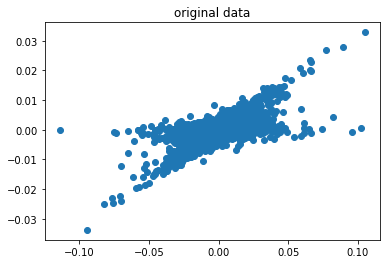

In [2]:
X_q1 = np.loadtxt('X_q1.txt').T
print(X_q1.shape)
plt.scatter(X_q1[0, :], X_q1[1, :])
_ = plt.title('original data')

(a)

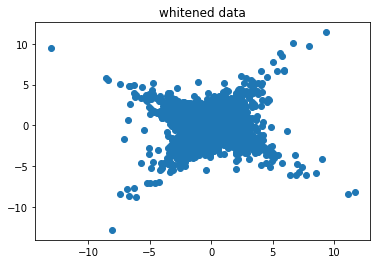

In [3]:
X_q1_cov = np.cov(X_q1)
v, b = np.linalg.eig(X_q1_cov)
d = np.array([[v[0], 0],
             [0, v[1]]])

X_q1_whitened = b @ fractional_matrix_power(d, -0.5) @ b.T @ X_q1

plt.scatter(X_q1_whitened[0, :], X_q1_whitened[1, :])
_ = plt.title('whitened data')

(b)

In [4]:
def rotation_matrix(theta):
    R = np.array([[np.cos(theta), -np.sin(theta)],
                 [np.sin(theta), np.cos(theta)]])
    return R

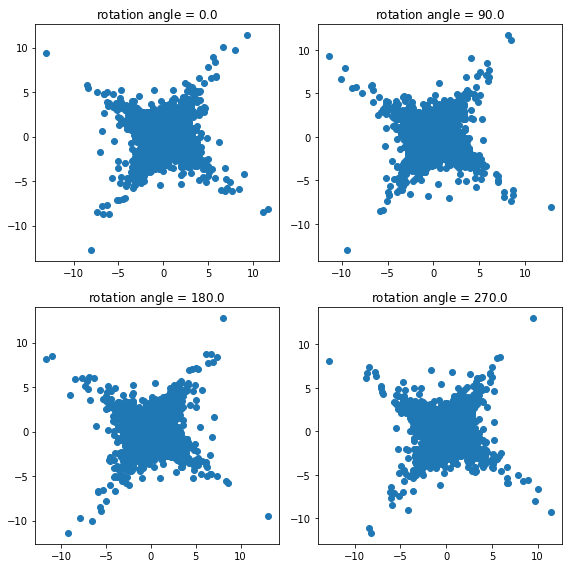

In [5]:
Y = np.zeros((360 * 2, X_q1.shape[0], X_q1.shape[1]))

angles = np.arange(0, 360, 0.5)

fig, ax = plt.subplots(2, 2, figsize=(8,8))
ax = ax.reshape(-1, 1)

for i in range(len(angles)):
    curr_ax = 0
    Y[i, :, :] = rotation_matrix(np.radians(angles[i])) @ X_q1_whitened
    
    if (angles[i] % 90 == 0):
        ax[np.int(angles[i]) // 90][0].scatter(Y[i, 0, :], Y[i, 1, :])
        ax[np.int(angles[i]) // 90][0].set_title('rotation angle = ${}$'.format(angles[i]))
        
plt.tight_layout()

(c)

In [6]:
def compute_entropy(Y, n_bins):
    hist, bin_edges = np.histogram(Y, bins=np.arange(n_bins), density=True)
    hist = hist[hist!=0]

    H = -np.sum((hist) * np.log(hist))
    return H

In [7]:
Y_entropies = np.zeros((360 * 2))

for i in range((len(angles))):
    n_bins = 100
    H_0 = compute_entropy(Y[i, 0, :], n_bins)
    H_1 = compute_entropy(Y[i, 1, :], n_bins)
    H = H_0 + H_1
    Y_entropies[i] = H

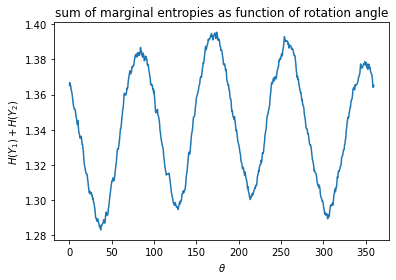

In [8]:
plt.plot(angles, Y_entropies)
plt.xlabel('$\\theta$')
plt.ylabel('$H(Y_1)+H(Y_2)$')
_ = plt.title('sum of marginal entropies as function of rotation angle')

(d)

In [9]:
Y_kurtosis = np.zeros((360 * 2))

for i in range((len(angles))):
    K_0 = kurtosis(Y[i, 0, :])
    K_1 = kurtosis(Y[i, 1, :])
    K = K_0 + K_1
    Y_kurtosis[i] = K

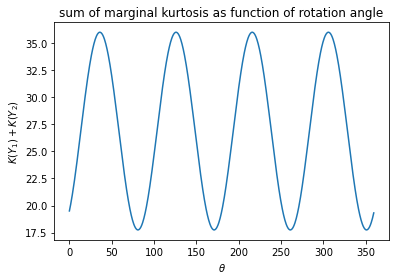

In [10]:
plt.plot(angles, Y_kurtosis)
plt.xlabel('$\\theta$')
plt.ylabel('$K(Y_1)+K(Y_2)$')
_ = plt.title('sum of marginal kurtosis as function of rotation angle')

The kurtosis is most non-Gaussian when the sum of marginal entropies is lowest. This makes sense because a Gaussian maximizes the entropy so a small entropy should be least Gaussian.

(e)

(1)
$$ X = A S$$ rewrite $$ A = X S^{-1}$$


(2)
$$ S = R_0 \tilde{X} $$ with $$ \tilde{X} = B D^{-\frac{1}{2}} B^T X $$

(3)
$$ A = X (R_0 B D^{-\frac{1}{2}} B^T X)^{-1} $$
$$ A = X X^{-1} (R_0 B D^{-\frac{1}{2}} B^T)^{-1} $$
$$ A = (R_0 B D^{-\frac{1}{2}} B^T)^{-1} $$


In [11]:
min_idx = np.argmin(Y_entropies)
R_0 = rotation_matrix(np.radians(angles[min_idx]))

A = np.linalg.inv(R_0 @ b @ fractional_matrix_power(d, -0.5) @ b.T)

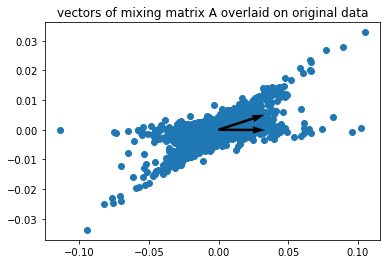

In [12]:
plt.scatter(X_q1[0, :], X_q1[1, :])
plt.quiver(0, 0, A[0,0], A[1,0], scale = 0.05)
plt.quiver(0, 0, A[0,1], A[1,1], scale = 0.05)
_ = plt.title('vectors of mixing matrix A overlaid on original data')

## 2. Blind Source Separation ##

(a)

In [13]:
X_q2 = np.loadtxt('X_q2.txt')

In [14]:
write('X1.wav', 44100, (X_q2[:, 0] / X_q2[:, 0].max()*10000).astype(np.int16))
write('X2.wav', 44100, (X_q2[:, 1] / X_q2[:, 1].max()*10000).astype(np.int16))
write('X3.wav', 44100, (X_q2[:, 2] / X_q2[:, 2].max()*10000).astype(np.int16))

Songs

- 1. Itsy bitsy spider
- 2. Row row row your boat
- 3. Head, Shoulders, Knees and toes

(b)

In [15]:
transformer = FastICA(random_state=0, whiten='unit-variance') # random_state=10 produces different order
S = transformer.fit_transform(X_q2)
S.shape

(441000, 3)

(c)

In [16]:
write('S1.wav', 44100, (S[:, 0] / S[:, 0].max()*10000).astype(np.int16))
write('S2.wav', 44100, (S[:, 1] / S[:, 1].max()*10000).astype(np.int16))
write('S3.wav', 44100, (S[:, 2] / S[:, 2].max()*10000).astype(np.int16))

Songs can be heard well but also not perfect reconstruction. E.g., itsy bitsy spider has still some background tones that do not belong.